In [145]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

In [146]:
global_epoch_number = 100

## Reading data

In [147]:
# reading data
evo_data = pd.read_csv('data/demand_datasets/evo_demand.csv', index_col=0)
modo_data = pd.read_csv('data/demand_datasets/modo_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [148]:
evo_data.columns

Index(['travels', 'tempC', 'precipMM', 'FeelsLikeC', 'uvIndex', 'visibility',
       'windspeedMiles', 'Blizzard', 'Clear', 'Cloudy', 'Fog', 'Heavy rain',
       'Heavy rain at times', 'Heavy snow', 'Light drizzle', 'Light rain',
       'Light rain shower', 'Light sleet', 'Light sleet showers', 'Light snow',
       'Mist', 'Moderate or heavy freezing rain',
       'Moderate or heavy rain shower', 'Moderate or heavy rain with thunder',
       'Moderate or heavy sleet', 'Moderate or heavy snow showers',
       'Moderate or heavy snow with thunder', 'Moderate rain',
       'Moderate rain at times', 'Moderate snow', 'Overcast', 'Partly cloudy',
       'Patchy heavy snow', 'Patchy light drizzle', 'Patchy light rain',
       'Patchy light rain with thunder', 'Patchy light snow',
       'Patchy moderate snow', 'Patchy rain possible', 'Patchy sleet possible',
       'Patchy snow possible', 'Sunny', 'Thundery outbreaks possible',
       'Torrential rain shower', 'Monday', 'Tuesday', 'Wednesday'

In [149]:
evo_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)
modo_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)
c2g_data.drop(columns = ['hour_0', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10',
       'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16',
       'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22',
       'hour_23'], inplace=True)

In [150]:
unievo_data = pd.DataFrame(evo_data.travels)
unimodo_data = pd.DataFrame(modo_data.travels)
unic2g_data = pd.DataFrame(c2g_data.travels)

In [151]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]

unievo_data = unievo_data[(unievo_data.index >= '2018-'+init_period) & (unievo_data.index <= '2018-'+end_period)]
unimodo_data = unimodo_data[(unimodo_data.index >= '2018-'+init_period) & (unimodo_data.index <= '2018-'+end_period)]
unic2g_data = unic2g_data[(unic2g_data.index >= '2017-'+init_period) & (unic2g_data.index <= '2017-'+end_period)]

## LSTM Data Preparation

In [152]:
def sup_learning_formatter(data, past_lags, future_steps, train_split):
    X = []
    y = []

    norm_data  = data.values

    for n in range(len(data) - past_lags - future_steps):
        X.append(norm_data[n : n + past_lags])
        y.append(data.travels.values[n + past_lags : n + past_lags + future_steps])
    return np.array(X), np.array(y)

In [153]:
def train_val_test_splitter(data, splits):
    print([int(len(data)*n) for n in splits])
    locs = [int(len(data)*n) for n in splits]
    return data[:locs[0]], data[locs[0]:locs[1]], data[locs[1]:], data[0].shape

In [154]:
def eval_model(y, y_hat):
    evaluation = {}
    evaluation["RMSE"] = np.sqrt(mean_squared_error(y, y_hat))
    evaluation["MAE"] = mean_absolute_error(y, y_hat)
    evaluation["R2"] = r2_score(y, y_hat)

    return evaluation

In [155]:
def run_lstm(data, past_lags, future_steps, splits, node_number, epochs=10, batch_size=10000, loss='mae'):
    
    X, y = sup_learning_formatter(data, past_lags, future_steps, splits[0])
    X_train, X_val, X_test, X_shape = train_val_test_splitter(X, splits)
    y_train, y_val, y_test, y_shape = train_val_test_splitter(y, splits)


    train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train = train.cache().shuffle(batch_size).batch(batch_size).repeat()

    val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val = val.batch(batch_size).repeat()

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(node_number, return_sequences=True,
                                  input_shape=X_shape))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(node_number, activation='relu'))
    model.add(tf.keras.layers.Dense(12))
    
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss=loss, metrics=[rmse])
    
    for x, y in val.take(1):
        print(model.predict(x).shape)
    
    history = model.fit(train, epochs=epochs, steps_per_epoch=50,
                        validation_data=val, validation_steps=50
                        )

    y_hat_test = model.predict(X_test)
    print(y_hat_test[0])
    evaluation = eval_model(y_test, y_hat_test)

    return model, history, (X_test, y_test), evaluation

In [156]:
def persistance_model(X, timesteps):
    y_hat = []
    for x in X:
        y_hat.append(np.array([x[-1][0] for _ in range(timesteps)]))

    return np.array(y_hat)

# Plot Generation

In [157]:
def performance_representation_plot(hour_skip, title, y_hat, y, title_in_plot=True, print_plot=True, upper_border=True, legend_font_size="medium",
                                    axis_value_size="medium", axis_label_size="medium"):
    
    
    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    data_predictions_array = np.array(data_predictions_array)
    data_truth_array = np.array(data_truth_array)
    
    fig = plt.figure(figsize=(20,10))
    plt.xlabel("Horas", fontdict={"fontsize":axis_label_size})
    plt.tick_params(axis="both", labelsize=axis_value_size)
    plt.title(title + " (Hours Skiped = " + str(hour_skip) + ")") if title_in_plot else print(title + " (Hours Skiped = " + str(hour_skip) + ")")
    plt.ylabel("Viagens requisitadas por hora", fontdict={"fontsize":axis_label_size})
    plt.plot(data_truth_array, marker="o", label="Valores Reais")
    plt.plot(data_predictions_array, marker="D", label="Valores Previstos")
    if(not upper_border):
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.legend(fontsize=legend_font_size)
    plt.show() if print_plot else print()

In [158]:
def save_performance_to_txt(name, y_hat, y, evaluation, hour_skip=12):

    data_predictions_array = []
    data_truth_array =  []
    
    for n in range(0, len(y), hour_skip):
        data_predictions_array.append(y_hat[n])
        data_truth_array.append(y[n])

    data_predictions_array = np.array(data_predictions_array).flatten()
    data_truth_array = np.array(data_truth_array).flatten()
    
    data_array = np.array([data_predictions_array, data_truth_array])
    np.savetxt(f'results/LSTM_{name}_Predictions_by{str(hour_skip) + "Hrs"}.txt', data_array, delimiter=",")

    json_eval = json.dumps(evaluation, indent = 4) 
    with open(f'results/LSTM_{name}_Results.json', "w") as outfile: 
        outfile.write(json_eval)

# Training Models

In [159]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(true_future), 'bo',
           label='True Future')
    plt.plot(np.arange(len(history),num_out+len(history)), np.array(prediction[0]), 'rX-',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [160]:
def plot_train_history(history, title, save_file=False):
    history = pd.DataFrame(history.history)

    history.plot(figsize=(8, 5))
    plt.grid(True)
    plt.savefig("plots\\" + title.replace(" ", "_") + ".png", bbox_inches='tight') if save_file else print()
    plt.show()

Next, will be generated the model for each dataset

## Evo Model

### Single Variable

In [161]:
print('Evo Model Single Var')
unievo_model, unievo_hist, unievo_test, unievo_eval = run_lstm(unievo_data, 24, 12, (0.6, 0.8), 50, epochs=global_epoch_number)

Evo Model Single Var
[136, 181]
[136, 181]
(45, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 7s 141ms/step - loss: 207.8191 - rmse: 278.3049 - val_loss: 153.4223 - val_rmse: 192.8109
Epoch 2/100
50/50 [==============================] - 4s 71ms/step - loss: 151.6116 - rmse: 212.1849 - val_loss: 131.2156 - val_rmse: 171.9745
Epoch 3/100
50/50 [==============================] - 3s 69ms/step - loss: 140.3563 - rmse: 198.3821 - val_loss: 126.8879 - val_rmse: 165.6240
Epoch 4/100
50/50 [==============================] - 4s 71ms/step - loss: 140.0377 - rmse: 197.4235 - val_loss: 138.4662 - val_rmse: 159.0294
Epoch 5/100
50/50 [==============================] - 4s 70ms/step - loss: 133.7932 - rmse: 188.9397 - val_loss: 136.9076 - val_rmse: 157.1883
Epoch 6/100
50/50 [==============================] - 3s 69ms/step - loss: 130.0180 - rmse: 186.2266 - val_loss: 149.5912 - val_rmse: 171.4453
Epoch 7/100
50/50 [==============================] - 

In [162]:
unievo_model.save(r'models/unievo_model')

INFO:tensorflow:Assets written to: models/unievo_model\assets


In [163]:
print(unievo_eval)
print(eval_model(unievo_test[1], persistance_model(unievo_test[0], 12)))

{'RMSE': 175.5311267410022, 'MAE': 112.0482971219049, 'R2': -0.01500173572361485}
{'RMSE': 241.07871256536507, 'MAE': 197.78985507246375, 'R2': -0.9059816693374572}


### Plotting prediction

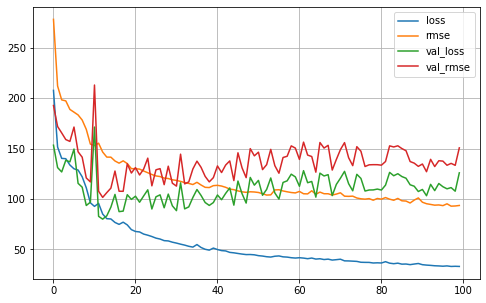

In [164]:
plot_train_history(unievo_hist, 'Training and validation loss')

In [165]:
save_performance_to_txt("Evo_Single_Variable",
                         unievo_model.predict(unievo_test[0]),
                         unievo_test[1], unievo_eval)

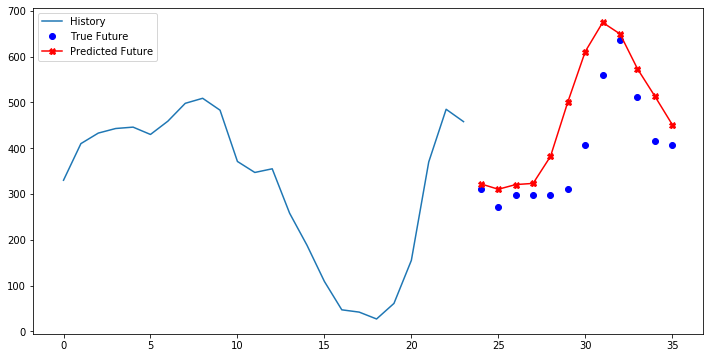

In [166]:
multi_step_plot(unievo_test[0][10], unievo_test[1][10], unievo_model.predict(np.array([unievo_test[0][10]])))

Evo Performance Univariavel (Hours Skiped = 12)


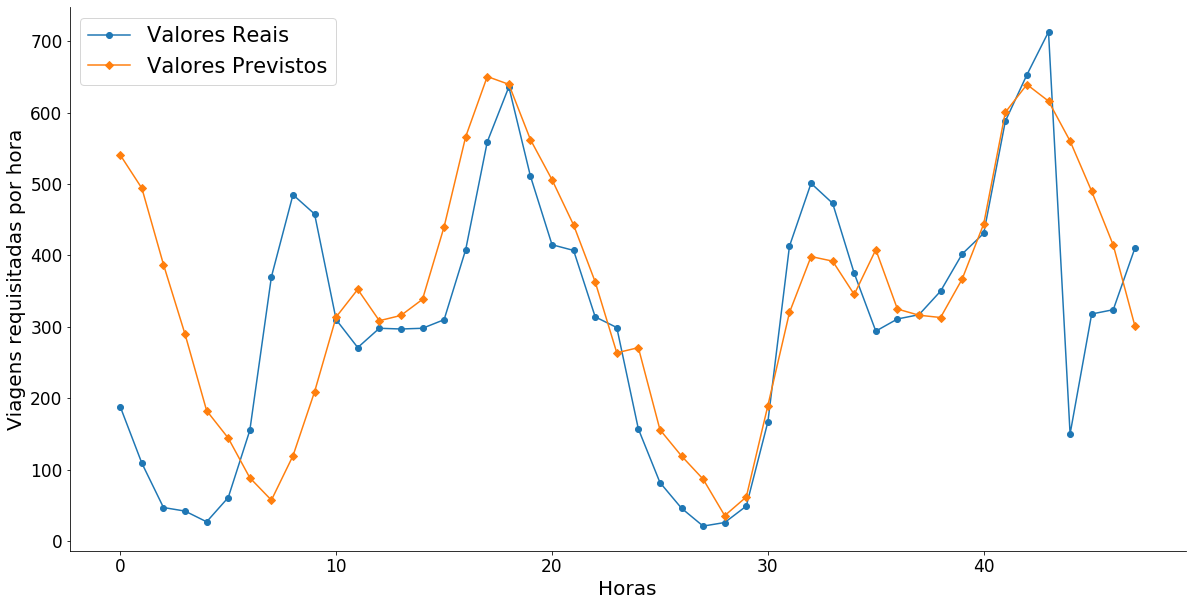

In [167]:
performance_representation_plot(12, 
                                "Evo Performance Univariavel",
                                unievo_model.predict(unievo_test[0]),
                                unievo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [168]:
print('Evo Model Multi Var')
evo_model, evo_hist, evo_test, evo_eval = run_lstm(evo_data, 24, 12, (0.6, 0.8), 80, epochs=global_epoch_number)

Evo Model Multi Var
[136, 181]
[136, 181]
(45, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 9s 190ms/step - loss: 206.5901 - rmse: 275.2963 - val_loss: 133.6431 - val_rmse: 170.7958
Epoch 2/100
50/50 [==============================] - 6s 121ms/step - loss: 150.8625 - rmse: 209.4473 - val_loss: 129.3875 - val_rmse: 169.9024
Epoch 3/100
50/50 [==============================] - 6s 123ms/step - loss: 134.7332 - rmse: 191.8585 - val_loss: 104.5399 - val_rmse: 131.0475
Epoch 4/100
50/50 [==============================] - 6s 121ms/step - loss: 115.8629 - rmse: 174.9024 - val_loss: 111.0128 - val_rmse: 142.0098
Epoch 5/100
50/50 [==============================] - 6s 123ms/step - loss: 97.1306 - rmse: 156.3639 - val_loss: 88.0404 - val_rmse: 110.9663
Epoch 6/100
50/50 [==============================] - 6s 120ms/step - loss: 88.5603 - rmse: 149.4841 - val_loss: 92.1051 - val_rmse: 115.9001
Epoch 7/100
50/50 [==============================] - 

In [169]:
evo_model.save(r'models/evo_model')

INFO:tensorflow:Assets written to: models/evo_model\assets


In [170]:
print(evo_eval)
print(eval_model(evo_test[1], persistance_model(evo_test[0], 12)))

{'RMSE': 154.53441158072633, 'MAE': 85.98244698842366, 'R2': 0.20636942838941286}
{'RMSE': 241.07871256536507, 'MAE': 197.78985507246375, 'R2': -0.9059816693374572}


### Plotting prediction

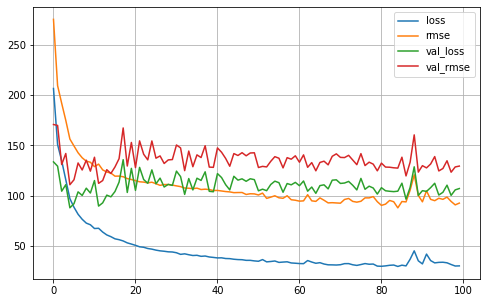

In [171]:
plot_train_history(evo_hist,
                   'Training and validation loss')

In [172]:
save_performance_to_txt("Evo_Multivariable",
                         evo_model.predict(evo_test[0]),
                         evo_test[1], evo_eval)


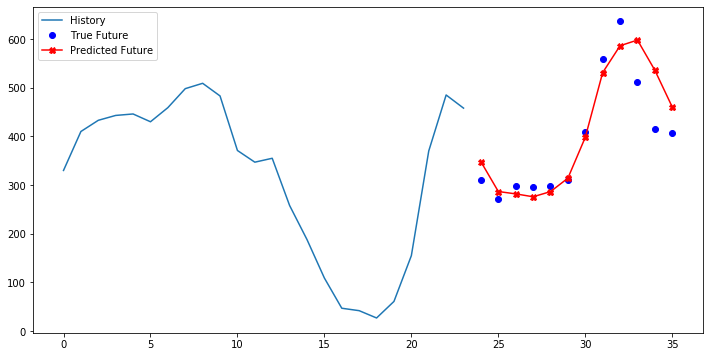

In [173]:
multi_step_plot(evo_test[0][10], evo_test[1][10], evo_model.predict(np.array([evo_test[0][10]])))

Evo Performance Multivariavel (Hours Skiped = 12)


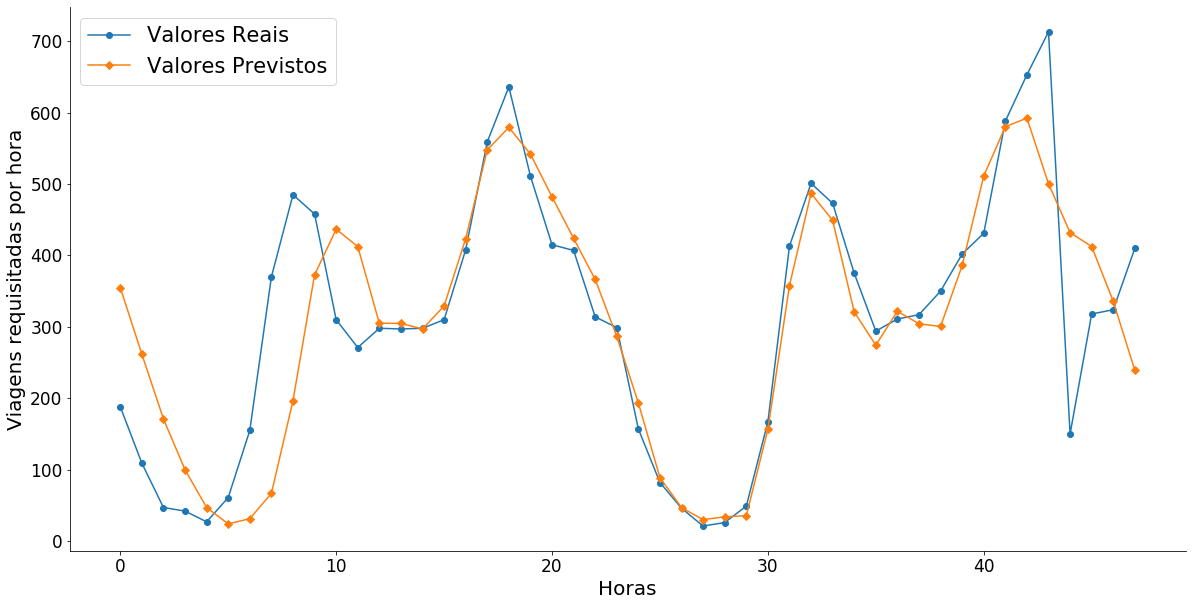

In [174]:
performance_representation_plot(12, 
                                "Evo Performance Multivariavel",
                                evo_model.predict(evo_test[0]),
                                evo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

## Modo model

### Single Variable

In [175]:
print('Modo Model')
unimodo_model, unimodo_hist, unimodo_test, unimodo_eval = run_lstm(unimodo_data, 24, 12, (0.6, 0.8), 50, epochs=global_epoch_number)

Modo Model
[215, 287]
[215, 287]
(72, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 8s 162ms/step - loss: 26.7674 - rmse: 37.8687 - val_loss: 17.2328 - val_rmse: 22.1433
Epoch 2/100
50/50 [==============================] - 5s 93ms/step - loss: 19.2090 - rmse: 30.8140 - val_loss: 21.8665 - val_rmse: 28.2110
Epoch 3/100
50/50 [==============================] - 5s 94ms/step - loss: 15.8536 - rmse: 28.5244 - val_loss: 21.0576 - val_rmse: 27.5565
Epoch 4/100
50/50 [==============================] - 5s 94ms/step - loss: 14.2304 - rmse: 27.3567 - val_loss: 10.8627 - val_rmse: 15.0939
Epoch 5/100
50/50 [==============================] - 5s 93ms/step - loss: 13.0980 - rmse: 26.4780 - val_loss: 14.4132 - val_rmse: 19.9086
Epoch 6/100
50/50 [==============================] - 5s 94ms/step - loss: 12.2067 - rmse: 25.8172 - val_loss: 11.1874 - val_rmse: 15.4949
Epoch 7/100
50/50 [==============================] - 5s 93ms/step - loss: 11.5320 - rms

In [176]:
unimodo_model.save(r'models/unimodo_model')

INFO:tensorflow:Assets written to: models/unimodo_model\assets


In [177]:
print(unimodo_eval)
print(eval_model(unimodo_test[1], persistance_model(unimodo_test[0], 12)))

{'RMSE': 24.168382095562375, 'MAE': 15.932267718569, 'R2': 0.21365213013284726}
{'RMSE': 38.957122678752945, 'MAE': 29.724537037037035, 'R2': -1.0510354200915273}


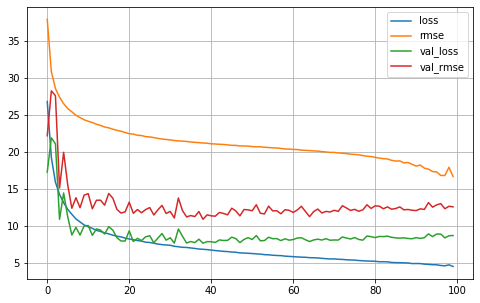

In [178]:
plot_train_history(unimodo_hist, 'Training and validation loss')

In [179]:
save_performance_to_txt("Modo_Single_Variable",
                         unimodo_model.predict(unimodo_test[0]),
                         unimodo_test[1], unimodo_eval)


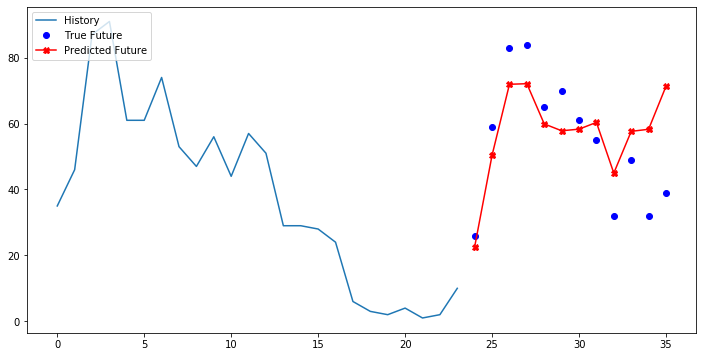

In [180]:
multi_step_plot(unimodo_test[0][10], unimodo_test[1][10], unimodo_model.predict(np.array([unimodo_test[0][10]])))

Modo Performance Univariavel (Hours Skiped = 12)


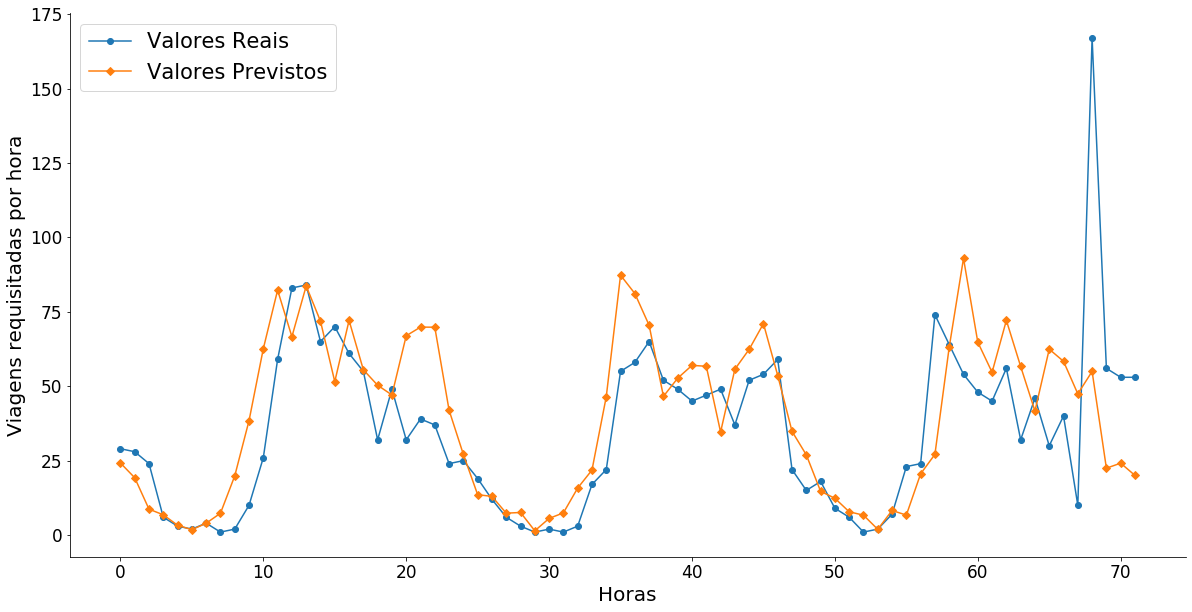

In [181]:
performance_representation_plot(12, 
                                "Modo Performance Univariavel",
                                unimodo_model.predict(unimodo_test[0]),
                                unimodo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [182]:
print('Modo Model')
modo_model, modo_hist, modo_test, modo_eval = run_lstm(modo_data, 24, 12, (0.6, 0.8), 80, epochs=global_epoch_number)

Modo Model
[215, 287]
[215, 287]
(72, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 13s 256ms/step - loss: 25.2764 - rmse: 36.5511 - val_loss: 17.3223 - val_rmse: 22.2783
Epoch 2/100
50/50 [==============================] - 9s 185ms/step - loss: 17.7190 - rmse: 29.5928 - val_loss: 12.1972 - val_rmse: 16.1664
Epoch 3/100
50/50 [==============================] - 9s 179ms/step - loss: 13.5594 - rmse: 26.6615 - val_loss: 11.4439 - val_rmse: 16.0838
Epoch 4/100
50/50 [==============================] - 9s 178ms/step - loss: 11.8552 - rmse: 25.3821 - val_loss: 13.4679 - val_rmse: 18.8112
Epoch 5/100
50/50 [==============================] - 9s 179ms/step - loss: 10.4841 - rmse: 24.2835 - val_loss: 11.2445 - val_rmse: 16.4643
Epoch 6/100
50/50 [==============================] - 9s 181ms/step - loss: 9.7504 - rmse: 23.6447 - val_loss: 12.2636 - val_rmse: 17.2467
Epoch 7/100
50/50 [==============================] - 9s 181ms/step - loss: 9.1482 

In [183]:
modo_model.save(r'models/modo_model')

INFO:tensorflow:Assets written to: models/modo_model\assets


In [184]:
print(modo_eval)
print(eval_model(modo_test[1], persistance_model(modo_test[0], 12)))

{'RMSE': 25.316469384379058, 'MAE': 15.946473649030343, 'R2': 0.14320515302803216}
{'RMSE': 38.957122678752945, 'MAE': 29.724537037037035, 'R2': -1.0510354200915273}


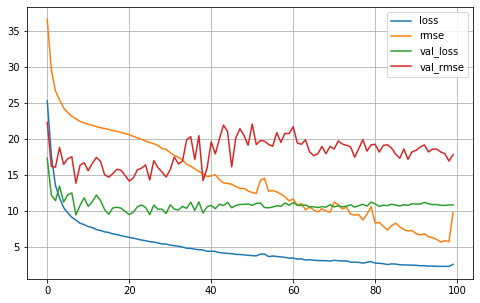

In [185]:
plot_train_history(modo_hist,
                   'Training and validation loss')

In [186]:
save_performance_to_txt("Modo_Multivariable",
                         modo_model.predict(modo_test[0]),
                         modo_test[1], modo_eval)


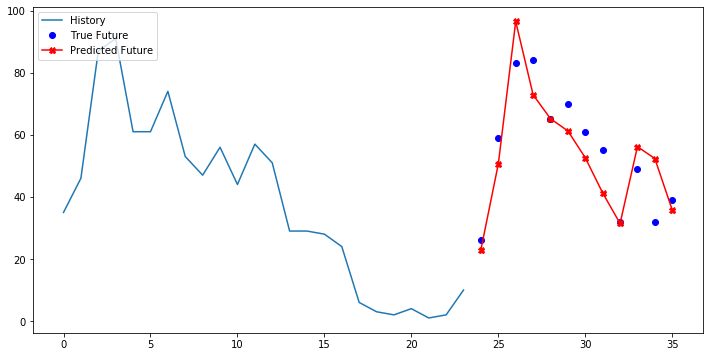

In [187]:
multi_step_plot(modo_test[0][10], modo_test[1][10], modo_model.predict(np.array([modo_test[0][10]])))

Modo Performance Multivariavel (Hours Skiped = 12)


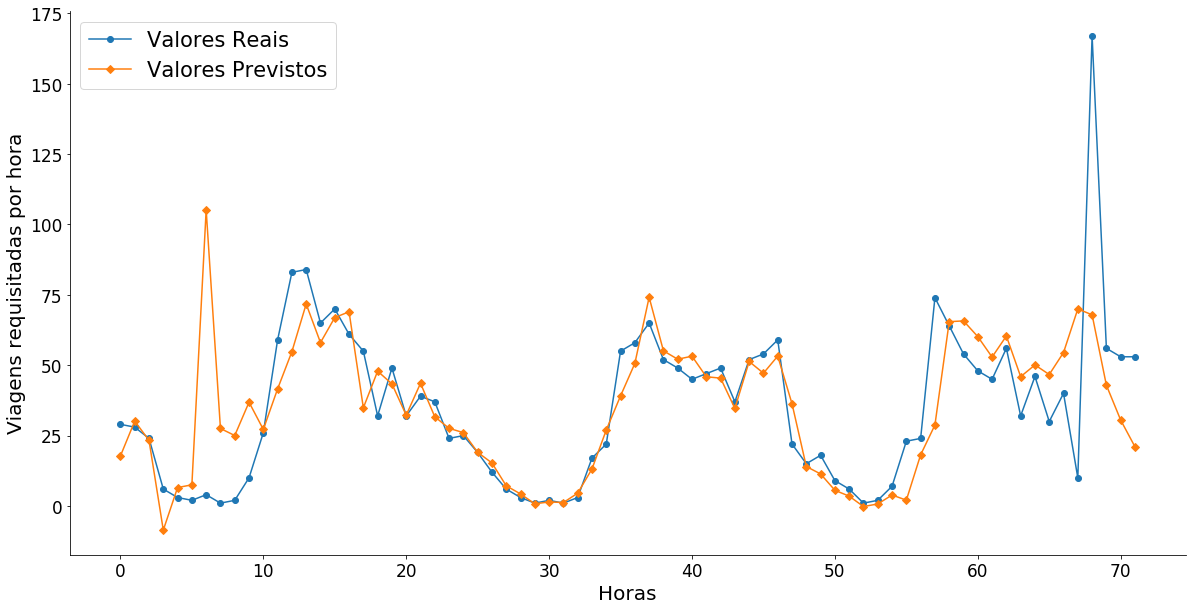

In [188]:
performance_representation_plot(12, 
                                "Modo Performance Multivariavel",
                                modo_model.predict(modo_test[0]),
                                modo_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

## Car2Go Model

### Single Variable

In [189]:
print('Car2Go Model')
unic2g_model, unic2g_hist, unic2g_test, unic2g_eval = run_lstm(unic2g_data, 24, 12, (0.6, 0.8), 50, epochs=global_epoch_number)

Car2Go Model
[241, 322]
[241, 322]
(81, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 9s 181ms/step - loss: 119.2043 - rmse: 143.8844 - val_loss: 102.4867 - val_rmse: 124.4751
Epoch 2/100
50/50 [==============================] - 5s 102ms/step - loss: 86.2674 - rmse: 106.1892 - val_loss: 84.0676 - val_rmse: 103.1157
Epoch 3/100
50/50 [==============================] - 5s 101ms/step - loss: 78.4432 - rmse: 97.4696 - val_loss: 81.7201 - val_rmse: 104.6162
Epoch 4/100
50/50 [==============================] - 5s 102ms/step - loss: 68.0713 - rmse: 87.6996 - val_loss: 61.2927 - val_rmse: 78.3445
Epoch 5/100
50/50 [==============================] - 5s 103ms/step - loss: 60.7398 - rmse: 81.3821 - val_loss: 65.2351 - val_rmse: 84.1868
Epoch 6/100
50/50 [==============================] - 5s 102ms/step - loss: 57.6845 - rmse: 78.9054 - val_loss: 49.1982 - val_rmse: 61.2880
Epoch 7/100
50/50 [==============================] - 5s 101ms/step - loss

In [190]:
unic2g_model.save(r'models/unic2g_model')

INFO:tensorflow:Assets written to: models/unic2g_model\assets


In [191]:
print(unic2g_eval)
print(eval_model(unic2g_test[1], persistance_model(unic2g_test[0], 12)))

{'RMSE': 41.27562927768791, 'MAE': 27.778356803297502, 'R2': 0.835925326229742}
{'RMSE': 148.40249809329094, 'MAE': 121.52983539094652, 'R2': -1.1362649026830889}


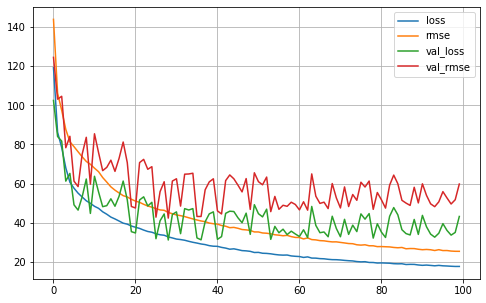

In [192]:
plot_train_history(unic2g_hist,
                   'Training and validation loss')

In [193]:
save_performance_to_txt("Car2Go_Single_Variable",
                         unic2g_model.predict(unic2g_test[0]),
                         unic2g_test[1], unic2g_eval)

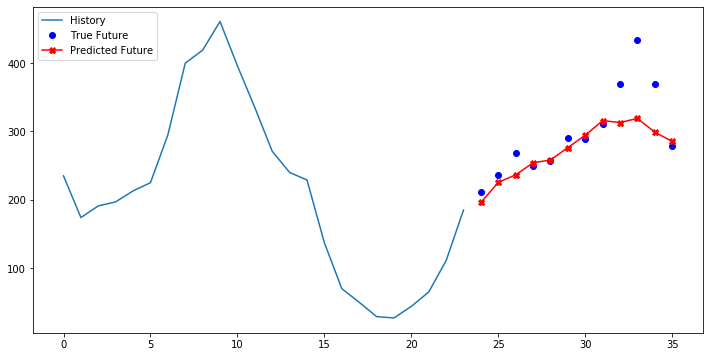

In [194]:
multi_step_plot(unic2g_test[0][10], unic2g_test[1][10], unic2g_model.predict(np.array([unic2g_test[0][10]])))

Car2Go Performance Univariável (Hours Skiped = 12)


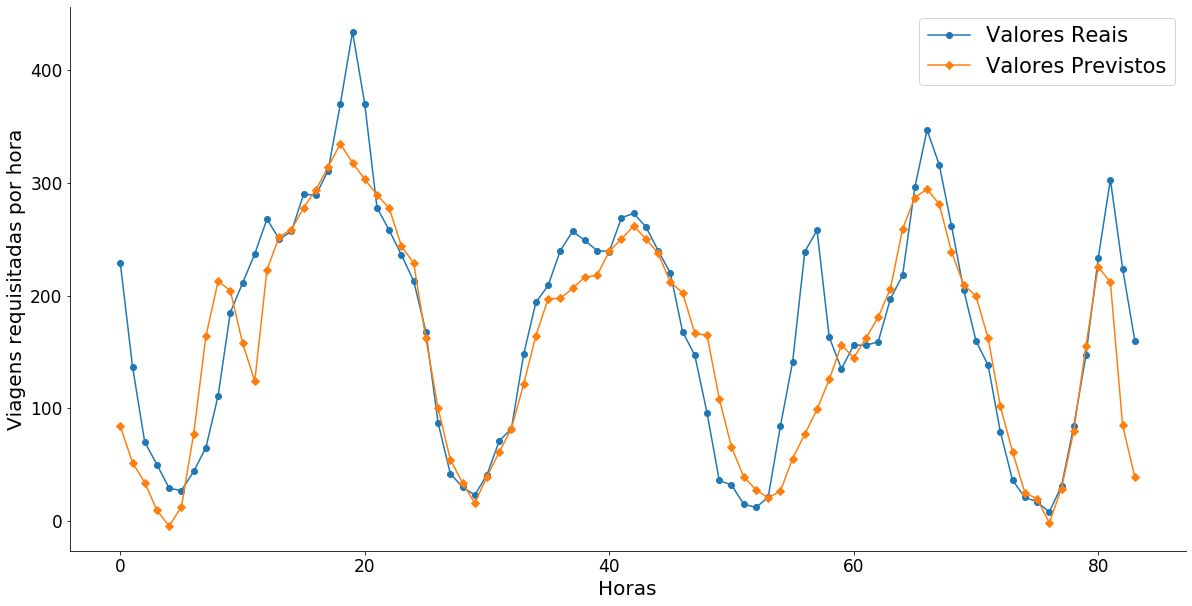

In [195]:
performance_representation_plot(12, 
                                "Car2Go Performance Univariável",
                                unic2g_model.predict(unic2g_test[0]),
                                unic2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

### Multi Variable

In [196]:
print('Car2Go Model')
c2g_model, c2g_hist, c2g_test, c2g_eval = run_lstm(c2g_data, 24, 12, (0.6, 0.8), 80, epochs=global_epoch_number)

Car2Go Model
[241, 322]
[241, 322]
(81, 12)
Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 15s 307ms/step - loss: 119.4211 - rmse: 144.2843 - val_loss: 88.2297 - val_rmse: 106.5793
Epoch 2/100
50/50 [==============================] - 10s 205ms/step - loss: 82.8223 - rmse: 102.6547 - val_loss: 66.7292 - val_rmse: 83.9350
Epoch 3/100
50/50 [==============================] - 9s 186ms/step - loss: 67.9449 - rmse: 86.3862 - val_loss: 82.8264 - val_rmse: 106.5659
Epoch 4/100
50/50 [==============================] - 9s 186ms/step - loss: 59.7847 - rmse: 77.0690 - val_loss: 65.2235 - val_rmse: 82.7953
Epoch 5/100
50/50 [==============================] - 9s 186ms/step - loss: 52.2274 - rmse: 67.8719 - val_loss: 56.2490 - val_rmse: 72.2737
Epoch 6/100
50/50 [==============================] - 9s 184ms/step - loss: 47.1331 - rmse: 61.9719 - val_loss: 72.2067 - val_rmse: 96.4863
Epoch 7/100
50/50 [==============================] - 9s 187ms/step - loss

In [197]:
c2g_model.save(r'models/c2g_model')

INFO:tensorflow:Assets written to: models/c2g_model\assets


In [198]:
print(c2g_eval)
print(eval_model(c2g_test[1], persistance_model(c2g_test[0], 12)))

{'RMSE': 35.172854887604224, 'MAE': 24.56004088359728, 'R2': 0.8808889495309097}
{'RMSE': 148.40249809329094, 'MAE': 121.52983539094652, 'R2': -1.1362649026830889}


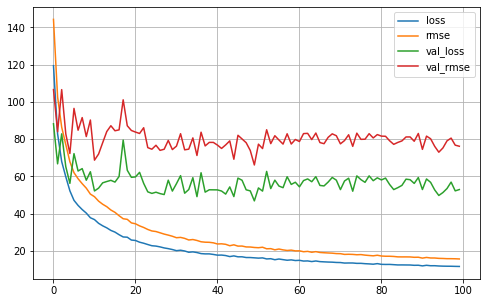

In [199]:
plot_train_history(c2g_hist, 'Training and validation loss')

In [200]:
save_performance_to_txt("Car2Go_Multivariable",
                         c2g_model.predict(c2g_test[0]),
                         c2g_test[1], c2g_eval)

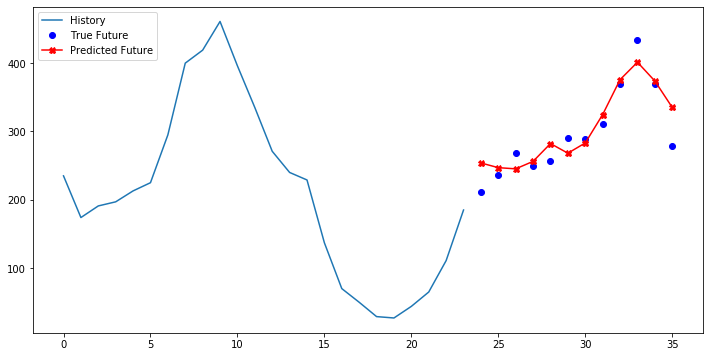

In [201]:
multi_step_plot(c2g_test[0][10], c2g_test[1][10], c2g_model.predict(np.array([c2g_test[0][10]])))

Car2Go Performance Multivariavel (Hours Skiped = 12)


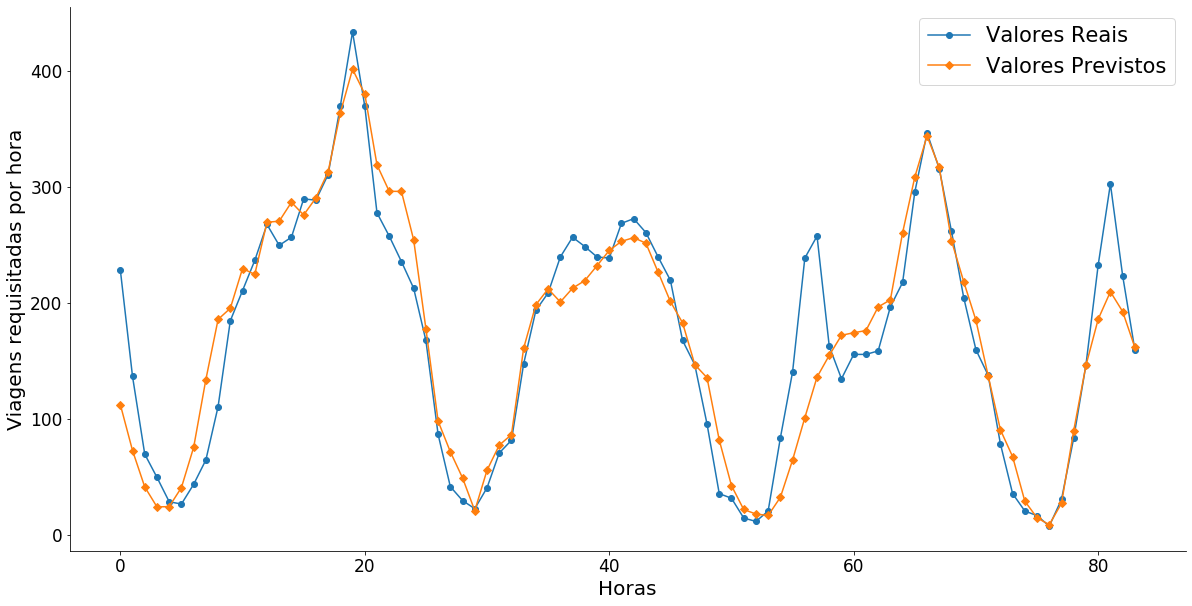

In [202]:
performance_representation_plot(12, 
                                "Car2Go Performance Multivariavel",
                                c2g_model.predict(c2g_test[0]),
                                c2g_test[1],
                                upper_border=False,
                                title_in_plot=False,
                                legend_font_size=21,
                                axis_label_size=20, 
                                axis_value_size=17,)

## Comparison Tables

In [203]:
evo_table = pd.DataFrame(data={"uni":unievo_eval, "multi":evo_eval})


performance_representation_plotrences

* https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series
* http://netlab.ice.ufjf.br/index.php/carsharingdata/